In [1]:
# Native Python imports (packages that come installed natively with Python)
import argparse
from collections import defaultdict
import datetime as dt
import logging
import sys
import os
import random
from itertools import product
import cProfile
from pstats import Stats
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor as Pool


mod_dir = os.path.dirname(os.getcwd()).split('/')[:-1]
mod_dir.append('src')
data_module_directory = os.path.join('/', *mod_dir)
sys.path.append(data_module_directory)

# External packages
import hdbscan
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
plt.style.use('default')
# plt.style.use('ggplot')
import matplotlib.dates as mdates
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import wandb
from anytree.exporter import DotExporter
from anytree import PreOrderIter

# Native packages
os.chdir("/home/jasminekobayashi/gh_repos/idea-lab-sw-isax")
import fdl21.data.helper_funcs as hf
import fdl21.isax_model as isax_model
import fdl21.visualization.isax_visualization as isax_vis

# new libraries
from copy import deepcopy


In [2]:
# Initialize Python Logger
logging.basicConfig(format='%(levelname)-4s '
                           '[%(module)s:%(funcName)s:%(lineno)d]'
                           ' %(message)s')
LOG = logging.getLogger()
LOG.setLevel(logging.INFO)


parser = argparse.ArgumentParser()
parser.add_argument(
    '-input_file',
    default=None,
    help='Input file containing a list of files to process'
)

parser.add_argument(
    '-start_date',
    default='2018-11-21',
    help='Start date for interval. Defaults to 2018-11-21.'
)
parser.add_argument(
    '-stop_date',
    default='2018-12-31',
    help='Stop date for interval. Defaults to 2018-12-31.'
)
parser.add_argument(
    '-cadence',
    default=1,
    help=(
        'Final cadence of interpolated timeseries in seconds.'
        'Defaults to 1 second.'
    ),
    type=int
)
parser.add_argument(
    '-chunk_size',
    default=300,
    help=(
        'Duration, in seconds, of each chunk of the timeseries'
        'Defaults to 300 seconds.'
    ),
    type=int
)
parser.add_argument(
    '-detrend_window',
    default=1800,
    help=(
        'Window size, in seconds, to use for detrending.'
        'Defaults to 1800 seconds.'
    ),
    type=int
)
parser.add_argument(
    '-max_cardinality',
    default=16,
    help='Maximum cardinality. Defaults to 16.',
    type=int
)
parser.add_argument(
    '-min_cardinality',
    default=8,
    help='Minimum cardinality. Defaults to 8.',
    type=int
)
parser.add_argument(
    '-node_level_depth',
    default=16,
    help=(
        'Deepest level to use when retrieving nodes.'
        'Defaults to 16.'
    ),
    type=int
)
parser.add_argument(
    '-smooth_window',
    default=2,
    help=(
        'Window size, in seconds, to use for smoothing.'
        'Defaults to [2].'
    ),
    type=int
)
parser.add_argument(
    '-threshold',
    default=200,
    help=(
        'Maximum number of timeseris a node can store.'
        'Defaults to 200.'
    ),
    type=int
)
parser.add_argument(
    '-word_size',
    default=10,
    help='SAX word length. Defaults to 10',
    type=int
)

parser.add_argument(
    '-overlap',
    default=0,
    help='Overlap used in chunking in seconds',
    type=int
)

parser.add_argument(
    '-cache',
    help='Flag that enables file cache.',
    default=False,
    action='store_true'
)

parser.add_argument(
    '-cache_folder',
    default='/cache/',
    help='Folder to place cache file'
)

parser.add_argument(
    '-min_cluster_size',
    default=5,
    help='Min cluster size for HDBScan implementation',
    type=int
)

parser.add_argument(
    '-min_samples',
    default=5,
    help='Min sample size for HDBScan implementation',
    type=int
)

parser.add_argument(
    '-transliterate',
    help='Creating the transliterating files from the clustered chunks',
    default=False,
    action='store_true'
)

parser.add_argument(
    '-instrument',
    default='psp',
    help='Instrument to analyze: psp or wind',
    type=str
)

parser.add_argument(
    '-cluster_selection_epsilon',
    default=None,
    help='Cluster selection epsilon for HDBScan as a percentile of the distance matrix distribution',
    type=float
)

parser.add_argument(
    '-n_processes',
    default=4,
    help='Number of processes for multipool',
    type=int
)

parser.add_argument(
    '-profiling',
    help='Runs profiler',
    default=False,
    action='store_true'
)

parser.add_argument(
    '-plot_cluster',
    help='Plot clusters',
    default=False,
    action='store_true'
)

parser.add_argument(
    '-parallel',
    help='Run parallel isax',
    default=False,
    action='store_true'
)


_StoreTrueAction(option_strings=['-parallel'], dest='parallel', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='Run parallel isax', metavar=None)

In [3]:
def plot_cluster_fig(clusterer, expected_val, cluster_file='clusters.png', metric='euclidean'):
    
    projection = TSNE(metric=metric).fit_transform(expected_val)

    (x,y) = projection.T[0], projection.T[1]

    color_palette = sns.color_palette('Paired', np.max(clusterer.labels_)+1)
    cluster_colors = [color_palette[x] if x >= 0
                    else (0.5, 0.5, 0.5)
                    for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                            zip(cluster_colors, clusterer.probabilities_)]
    fig, ax =plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=1)
    ax.set_xlabel('TSNE 1')
    ax.set_ylabel('TSNE 2')
    fig.savefig(cluster_file, format='png', dpi=200, bbox_inches='tight')
    return fig


def node_expected_val(node):
    """Function that returns the node expected value for parallelization

    Parameters
    ----------
    nodes : anytree node
        nodes to retrieve expected values for
    
    return
    ----------
    expected_val: np.array
        expected value for each letter of the node name
    """

    node_bkpt = node._do_bkpt()
    return node_bkpt[2]

def cluster_function(
    nodes_at_level,
    min_cluster_size=5,
    min_samples=5,
    cluster_selection_epsilon=None,
    metric='euclidean',
    n_processes=4
):

    LOG.info('Retrieving expected values...')

    expected_val = []
    for node in tqdm(nodes_at_level):
        node_bkpt = node._do_bkpt()
        expected_val.append(node_bkpt[2])

    # chunksize = int(np.ceil(len(nodes_at_level)/n_processes))
    # if chunksize < 4:
    #     chunksize=1
    # expected_val = process_map(node_expected_val, 
    #                             nodes_at_level,
    #                             max_workers=n_processes,
    #                             chunksize=chunksize)
    expected_val = np.array(expected_val)

    LOG.info('Running clustering of nodes...')

    if cluster_selection_epsilon is None:
        clusterer = hdbscan.HDBSCAN(metric=metric, min_cluster_size=min_cluster_size, min_samples=min_samples)
    else:
        LOG.error("epsilon is no longer functional")
        raise(NotImplementedError('epsilon not functional'))
        # epsilon = np.percentile(distance_matrix.reshape(-1)[distance_matrix.reshape(-1)>0], cluster_selection_epsilon/2)
        # LOG.info(f'Mean distance={np.median(distance_matrix.reshape(-1)[distance_matrix.reshape(-1)>0])}, cluster_selection_epsilon={epsilon} at {cluster_selection_epsilon} percentile')
        # clusterer = hdbscan.HDBSCAN(metric=metric, min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)

    clusterer.fit(expected_val)
    return clusterer, expected_val


def plot_cluster_curves(cluster, 
                        clusterer, 
                        component, 
                        node_level_depth,
                        isax_pipe, 
                        colors=100,
                        max_t = 600,
                        cache=False,
                        cache_folder=None,
                        percentiles = [[10,90], [20,80], [30,70], [40,60]],
                        instrument='psp'
                        ):
    """Function to plot the curves and information associated with a cluster

    Parameters
    ----------
    cluster : int
        number of cluster to print
    clusterer : hdbscan clusterer
        hdbscan clustering of nodes
    component : str
        component to plot
    ntimeseries : datetime
        [description]
    colors : list
        randomly generated list of colors used to generate clusters
    max_t : int
        The maximum time in seconds -- default set to 600s
    """
                        

    node_index = (clusterer.labels_== cluster).nonzero()[0]
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 4), dpi=300)
    nodes = [isax_pipe.nodes_at_level[component][node_level_depth][i] for i in node_index]
 
    v = isax_vis.iSaxVisualizer()
    colours = v.colours(colors)
    linestyles = v.linestyles(colors)
    
    custom_cycler = plt.cycler(color=colours) + plt.cycler(ls=linestyles)

    ax[0].set_prop_cycle(custom_cycler)

    _, _, end_time, n_sequences = v.plot_node_curves(ax[0], nodes, isax_pipe, 
                                        reload=True, 
                                        cache=cache, 
                                        cache_folder=cache_folder, 
                                        as_area=True, 
                                        plot_median=True, 
                                        max_t=max_t, 
                                        alpha=0.2, 
                                        percentiles=percentiles,
                                        instrument=instrument, 
                                        color='b',
                                        ec='None')

    v.plot_bkpts(ax[0], isax_pipe, component, cardinality=8, x_pos=None, add_text=False, color='r', ls='--', alpha=0.5, lw=0.5)
    v.letter_bounds(ax[0], nodes[0], 0, end_time, color='k', ls=':', alpha=0.3)

    shaded_region = True
    legend_artists = []
    node_names = []
    for i,node in enumerate(nodes):
        color = custom_cycler.by_key()['color'][i%100]
        ls = custom_cycler.by_key()['linestyle'][i%100]

        l, = ax[1].plot([-1, -1], [0, 0], color=color, ls=ls)
        legend_artists.append(l)
        node_names.append(node.short_name)

        v.shaded_word(ax[1], node, st=0, et=end_time, alpha=0.2, color=color)
        v.plot_node_curves(ax[2], [node], isax_pipe, reload=True, as_area=False, plot_median=True, max_t=max_t,
                            alpha=0.5, color=color, ls=ls, cache=cache, 
                            cache_folder=cache_folder, instrument=instrument)

        if shaded_region:
            shaded_region = False

    v.plot_bkpts(ax[1], isax_pipe, component, cardinality=8, x_pos=None, add_text=True, color='r', ls='--', alpha=0.5, lw=0.5)
    v.plot_bkpts(ax[2], isax_pipe, component, cardinality=8, x_pos=None, add_text=False, color='r', ls='--', alpha=0.5, lw=0.5)

    ax[1].set_xlabel(ax[0].get_xlabel())

    ax[2].yaxis.set_label_position("right")
    ax[2].yaxis.tick_right()

    ax[0].set_ylabel('B (nT)')
    ax[2].set_ylabel('B (nT)')

    ax[1].set_xlim(ax[0].get_xlim())
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].legend(legend_artists, node_names, bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2, frameon=False)

    fig.suptitle(f'Cluster {cluster}, N={n_sequences}', y=0.9, va='bottom')

    return fig

 
def plot_node(
    node,
    isax_pipe,
    component,
    ntimeseries = 5,
    colors = 100,
    max_t = 600,
    cache=False, 
    cache_folder=None,
    instrument='psp'
):
    """Some code for plotting timeseries data at a node and 
    it's corresponding raw data

    Parameters
    ----------
    isax_pipe : bool
        [description]
    component : str
        [description]
    ntimeseries : datetime
        [description]
    colors : list
        randomly generated list of colors used to generate clusters
    max_t : int
        The maximum time in seconds -- default set to 600s
    """
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=300)

    v = isax_vis.iSaxVisualizer()

    colours = v.colours(colors)
    linestyles = v.linestyles(colors)
    custom_cycler = plt.cycler(color=colours) + plt.cycler(ls=linestyles)

    ax[0].set_prop_cycle(custom_cycler)

    v.plot_node_curves(ax[0], [node], isax_pipe, reload=True, ntimeseries=ntimeseries, as_area=True, plot_median=False, percentiles=[[0,100]],
                        cache=cache, cache_folder=cache_folder, instrument=instrument, max_t=max_t, color='k', alpha=0.2, edgecolor='None')
    _, _, end_time, n_sequences = v.plot_node_curves(ax[0], [node], isax_pipe, reload=True, ntimeseries=ntimeseries, as_area=False, max_t=max_t, cache=cache, 
                        cache_folder=cache_folder)
    v.plot_bkpts(ax[0], isax_pipe, component, cardinality=8, x_pos=None, add_text=True, color='r', ls='--', alpha=0.5, lw=0.5)
    v.letter_bounds(ax[0], node, 0, end_time, color='k', ls=':', alpha=0.3)

    ax[1].set_prop_cycle(None)
    ax[1].set_prop_cycle(custom_cycler)

    dates, node_names = v.plot_raw_data(ax[1], [node], isax_pipe, reload=True, ntimeseries=ntimeseries, cache=cache, 
                                        cache_folder=cache_folder, instrument=instrument)

    ax[1].legend(dates.index.strftime('%Y-%m-%d %H:%M'), bbox_to_anchor=(-0.1, -0.15), loc='upper center', ncol=3, frameon=False)

    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()

    ax[0].set_ylabel('B (nT)')
    ax[1].set_ylabel('B (nT)')

    fig.suptitle(f'{node.short_name}, N={node.nb_sequences}', y=0.9, va='bottom')
    
    return fig

def colours(N):
    """
    creates a list of random hex colours Parameters:
    -----------
    N: int
        the lenght of the array or list used for 
        plotting 
    """
    chars = '0123456789ABCDEF'
    col = ['#'+''.join(random.sample(chars,6)) for i in range(N)]
    return col

def push_to_cloud(pdf_file, dirname, relative_folder=None):
    """Push the generate files to the bucket

    Parameters
    ----------
    pdf_file : [type]
        [description]
    """

    if relative_folder is not None:
        file_path = os.path.join(
            os.getcwd(),
            relative_folder,
            pdf_file
        )
    else:
        file_path = os.path.join(
            os.getcwd(),
            pdf_file
        )
    LOG.info(file_path)
    cmd = (
        f"gsutil -m cp -v {file_path} gs://isax-experiments-results/{dirname}/{pdf_file}"
    )
    os.system(cmd)

def build_cache(
        file,
        cadence=dt.timedelta(seconds=1),
        chunk_size=dt.timedelta(seconds=300),
        overlap=dt.timedelta(seconds=0),
        smooth_window=dt.timedelta(seconds=5),
        detrend_window=dt.timedelta(seconds=1800),
        cache_folder='/cache/',
        instrument='psp'      
    ):

    if instrument == 'psp':
        catalog_fname = 'psp_master_catalog_2018_2021_rads_norm.csv' 
    elif instrument == 'wind':
        catalog_fname = 'wind_master_catalog_2006_2022.csv'     
    elif instrument == 'omni':
        catalog_fname = 'omni_master_catalog_1994_2023.csv'

    if instrument == 'omni':
        orbit_fname = None
    else:
        orbit_fname = 'psp_orbit.csv'

    isax_pipe_dummy = isax_model.iSaxPipeline(
        orbit_fname = orbit_fname,
        catalog_fname = catalog_fname,
        instrument=instrument
    )

    return isax_pipe_dummy.build_cache(
            file=file,
            cadence=cadence,
            chunk_size=chunk_size,
            overlap = overlap,
            rads_norm=True,
            smooth=True,
            smooth_window=smooth_window,
            detrend=True,
            detrend_window=detrend_window,
            optimized=True,
            cache_folder=cache_folder,
            instrument=instrument
        )


In [4]:
# %% Parameters
# def run_experiment(
input_file = None
start_date=dt.datetime(2018, 1, 1)          #not default
stop_date=dt.datetime(2018, 6, 1)           #not default
min_cardinality = 8
max_cardinality = 32
word_size = 5                               #not default
threshold = 200
mu_x = 0.
std_x = 3.5
mu_y = 0.
std_y = 3.4
mu_z = 0.
std_z = 3.4
cadence=dt.timedelta(seconds=60)            #not default
chunk_size=dt.timedelta(seconds=3000)       #not default
smooth_window=dt.timedelta(seconds=18000)   #not default
detrend_window=dt.timedelta(seconds=3000)   #not default
overlap = dt.timedelta(seconds=0)
node_level_depth = 2
min_cluster_size = 5
min_samples = 5
cache=True                                  #not default
cache_folder= "/home/jasminekobayashi/isax_cache/"  #not default
transliterate = False
instrument='omni'                           #not default
cluster_selection_epsilon=None
n_processes=4
profiling=False
plot_cluster=True                           #not default
parallel = False

In [5]:
"""Run the iSAX experiment

Parameters
----------
input_file : [type], optional
    [description], by default None
start_date : [type], optional
    [description], by default dt.datetime(2018, 11, 21)
stop_date : [type], optional
    [description], by default dt.datetime(2018, 12, 31)
min_cardinality : int, optional
    [description], by default 8
max_cardinality : int, optional
    [description], by default 32
word_size : int, optional
    [description], by default 10
threshold : int, optional
    [description], by default 200
mu_x : [type], optional
    [description], by default 0.
std_x : float, optional
    [description], by default 3.5
mu_y : [type], optional
    [description], by default 0.
std_y : float, optional
    [description], by default 3.4
mu_z : [type], optional
    [description], by default 0.
std_z : float, optional
    [description], by default 3.4
cadence : [type], optional
    [description], by default dt.timedelta(seconds=1)
chunk_size : [type], optional
    [description], by default dt.timedelta(seconds=300)
smooth_window : int, optional
    [description], by default 2
detrend_window : int, optional
    [description], by default 1800
node_level_depth : int, optional
    [description], by default 16
min_node_size : int
    Minimum node size to include in clustering
transliterate : int, optional
    [description], by default False
instrument: string
        instrument to analyze        
"""
# Cluster selection epsilon text (for pdf filename)
if cluster_selection_epsilon is None:
    cse_text = 'NA'
else:
    cse_text = str(int(cluster_selection_epsilon*10))


run_prefix = f'CS{chunk_size.seconds}_C{cadence.seconds}_SW{smooth_window.seconds}_DW{detrend_window.seconds}_O{overlap.seconds}_{instrument}'
pdf_file = run_prefix + f'_WS{word_size}_CA{min_cardinality}_{max_cardinality}_MCS{min_cluster_size}_MS{min_samples}_T{threshold}_NLD{node_level_depth}_CSE{cse_text}'
cache_folder =  cache_folder + run_prefix + '/'
v = isax_vis.iSaxVisualizer()

# Data catalog file name to access based on instrument
if instrument == 'psp':
    catalog_fname = 'psp_master_catalog_2018_2021_rads_norm.csv' 
elif instrument == 'wind':
    catalog_fname = 'wind_master_catalog_2006_2022.csv'
elif instrument == 'omni':
    catalog_fname = 'omni_master_catalog_1994_2023.csv'

# Orbit file
if instrument == 'omni':
    orbit_fname = None
else: 
    orbit_fname = 'psp_orbit.csv'

# Instantiate iSax model Pipeline
isax_pipe = isax_model.iSaxPipeline(
    orbit_fname = orbit_fname,
    catalog_fname = catalog_fname,
    threshold = threshold,
    word_size = word_size,
    min_cardinality = min_cardinality,
    max_cardinality = max_cardinality,
    mu_x = mu_x,
    std_x = std_x,
    mu_y = mu_y,
    std_y = std_y,
    mu_z = mu_z,
    std_z = std_z,
    instrument=instrument
)   

if input_file is None:
    catalog_cut = isax_pipe.catalog[start_date:stop_date]
    flist = list(catalog_cut['fname'].values)
    LOG.info(f'Found {len(flist)} between {start_date} {stop_date}')
else:
    catalog_cut = pd.read_csv(input_file, header=0, index_col=0, parse_dates=True)
    flist = list(catalog_cut['fname'].values)
    LOG.info(f'Analyzing {len(flist)} between {catalog_cut.index[0]} {catalog_cut.index[-1]}')

# Running the cache once to build the cache files, if the cache has not made up to the generation of the histogram
histogram_file = cache_folder + run_prefix + '_hist_' + str(len(flist)) + '.npz'
cache_file = Path(histogram_file)
if cache and not cache_file.is_file():

    cache_list = list(product(
                        flist,
                        [cadence],
                        [chunk_size],
                        [overlap],
                        [smooth_window],
                        [detrend_window],
                        [cache_folder],
                        [instrument]                            
                        ))

    (flist_mp,
    cadence_mp,
    chunk_size_mp,
    overlap_mp,
    smooth_window_mp,
    detrend_window_mp,
    cache_folder_mp,
    instrument_mp) = map(list, zip(*cache_list))
                                    
    LOG.info('Building cache in parallel...')

    chunksize = int(np.ceil(len(flist_mp)/n_processes))
    if chunksize < 4:
        chunksize=1        
    process_map(build_cache,
                flist_mp,
                cadence_mp,
                chunk_size_mp,
                overlap_mp,
                smooth_window_mp,
                detrend_window_mp,
                cache_folder_mp,
                instrument_mp,
                max_workers=n_processes,
                chunksize = chunksize)

# Running the cache twice to calculate the histogram, means and stds
if cache:
    # bad_files = []
    # good_files = []

    # Check if a histogram cache file already exists
    histogram_file = cache_folder + run_prefix + '_hist_' + str(len(flist)) + '.npz'
    cache_file = Path(histogram_file)
    if cache_file.is_file():
        LOG.info('Restoring pre-calculated histogram')
        variables = np.load(histogram_file, allow_pickle=True)
        isax_pipe.bins = variables['bins'].ravel()[0]['bins']
        isax_pipe.hist = variables['hist'].ravel()[0]
    else:
        for file in tqdm(flist, desc=f'Creating file caches and histograms...'):
            isax_pipe.mag_df = None

            try:
                isax_pipe.build_cache(
                    file=file,
                    cadence=cadence,
                    chunk_size=chunk_size,
                    overlap = overlap,
                    rads_norm=True,
                    smooth=True,
                    smooth_window=smooth_window,
                    detrend=True,
                    detrend_window=detrend_window,
                    optimized=True,
                    cache_folder=cache_folder,
                    instrument=instrument
                )
                # good_files.append(True)
            except:
                pass
                # bad_files.append(file)
                # good_files.append(False)

        np.savez(histogram_file, 
                bins = {'bins': isax_pipe.bins},
                hist = isax_pipe.hist) 

    LOG.info('Recalculating mean and standard deviations.')
    bins = isax_pipe.bins
    delta = np.nanmedian(bins[1:]-bins[0:-1])
    centers = (bins[1:]+bins[0:-1])/2
    for component in ['x', 'y', 'z']:
        hist = isax_pipe.hist[component]
        mu = np.sum(centers*hist*delta)/np.sum(hist*delta)
        
        sig = np.sum(np.power(centers-mu, 2)*hist*delta)
        sig = sig/np.sum(hist*delta)
        sig = np.sqrt(sig)

        isax_pipe._mu[component] = mu
        isax_pipe._std[component] = sig            
        LOG.info(f'mu = {mu} and sig={sig} for ' + component + ' component')

for file in tqdm(flist, desc=f'Running pipeline...'):
    isax_pipe.mag_df = None

    isax_pipe.run_pipeline(
        flist=[file],
        cadence=cadence,
        chunk_size=chunk_size,
        overlap = overlap,
        rads_norm=True,
        smooth=True,
        smooth_window=smooth_window,
        detrend=True,
        detrend_window=detrend_window,
        optimized=True,
        cache_folder=cache_folder,
        cache=cache,
        instrument=instrument,
        parallel = parallel
    )

if parallel:
    for component in ['x', 'y', 'z']:
        isax_pipe.sw_forest[component].forest[0].parallel_escalation()

node_sizes = defaultdict(list)
LOG.info('Getting nodes for files')
for component in ['x', 'y', 'z']:
    isax_pipe.get_nodes_at_level(
        component=component,
        node_level=node_level_depth
    )
    for node in isax_pipe.nodes_at_level[component][node_level_depth]:
        node_sizes[component].append(len(node.get_annotations()))

for component in ['x', 'y', 'z']:
    node_sizes[component] = pd.Series(node_sizes[component])
    node_sizes[component].sort_values(ascending=False, inplace=True)

date_time = str(dt.datetime.now().strftime('%Y%m%d%H%M'))
# wandb.init(
#     entity='solar-wind', 
#     name=f'{pdf_file}_{date_time}',
#     project='CB_week_8_60_full_'+instrument, 
#     job_type='plot-isax-node',
#     config=isax_pipe.input_parameters
# )

if not os.path.exists('runs'):
    os.makedirs('runs')


parameter_file = isax_pipe.save(
    fname= 'runs/' + pdf_file + '.json',
    overwrite=True
)


dirname = pdf_file

# push_to_cloud(parameter_file.split('/')[1], dirname=dirname + '_' + date_time, relative_folder='runs/')

if transliterate:
    component_annotations = {'x': {},'y': {}, 'z': {}}
    for component in component_annotations.keys():
        component_annotations[component] = {
                                            'File': [],
                                            'Component': [],
                                            't0': [],
                                            't1': [],
                                            'chunk_num': [],
                                            f'cluster {component}': [],
                                            f'p_node {component}': []
                                        }

component_dict_wand = {}

INFO [2580517646:<module>:94] Found 6 between 2018-01-01 00:00:00 2018-06-01 00:00:00
INFO [2580517646:<module>:151] Restoring pre-calculated histogram
INFO [2580517646:<module>:184] Recalculating mean and standard deviations.
INFO [2580517646:<module>:198] mu = -0.00024481566749151595 and sig=0.03966107337392552 for x component
INFO [2580517646:<module>:198] mu = -0.000662442395602122 and sig=0.041391676065254596 for y component
INFO [2580517646:<module>:198] mu = -0.00028321812524881204 and sig=0.046502238547740334 for z component
Running pipeline...:   0%|          | 0/6 [00:00<?, ?it/s]

INFO [isax_model:generate_nodes:680] Total duration: 0.472 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:680] Total duration: 0.353 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:680] Total duration: 0.345 seconds
------------------------------------------------------------
INFO [isax_model:run_pipeline:1036] Finished processing all files...
Total duration: 1.350 seconds
------------------------------------------------------------
Running pipeline...:  17%|█▋        | 1/6 [00:01<00:06,  1.35s/it]INFO [isax_model:generate_nodes:680] Total duration: 0.300 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:680] Total duration: 0.360 seconds
------------------------------------------------------------
INFO [isax_model:generate_nodes:680] Total duration: 0.371 seconds
------------------------------------------------------------
INFO [

In [6]:
# for component in ['x','y','z']:
component = 'x' #just use x-component (for now)
nodes_at_level = isax_pipe.sw_forest[component].forest[0].get_nodes_of_level_or_terminal(node_level_depth)

## Clustering
hdbscan_clusters, expected_val = cluster_function(
    nodes_at_level,
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    cluster_selection_epsilon=cluster_selection_epsilon,
    n_processes=n_processes
)

INFO [2890530314:cluster_function:47] Retrieving expected values...
100%|██████████| 2839/2839 [00:00<00:00, 12048.85it/s]
INFO [2890530314:cluster_function:63] Running clustering of nodes...


In [7]:
print(np.unique(hdbscan_clusters.labels_))
print(hdbscan_clusters.labels_.shape)
print(expected_val.shape)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29]
(2839,)
(2839, 5)


In [8]:
if transliterate:

    for cluster in tqdm(np.arange(np.min(hdbscan_clusters.labels_), np.max(hdbscan_clusters.labels_)+1), 
                                desc=f'Transliterating nodes...'):
        node_index = (hdbscan_clusters.labels_==cluster).nonzero()[0]
        nodes = [nodes_at_level[i] for i in node_index]

        for node in nodes:

            annotations = node.get_annotations()
            for key, value in annotations.items():
                component_annotations[component][key] += value
            
            component_annotations[component][f'cluster {component}'] += [cluster] * len(annotations['File'])        
            component_annotations[component][f'p_node {component}'] += [node.short_name] * len(annotations['File'])        

In [9]:
# save copy so that original hdbscan_clusters is unaffected
reindexed_cluster = deepcopy(hdbscan_clusters)     

# Largest Cluster ("flat" cluster)

In [10]:
# Find the biggest cluster
largest_cluster_label = np.bincount(hdbscan_clusters.labels_[hdbscan_clusters.labels_!=-1]).argmax()
print(largest_cluster_label)
# print(largest_cluster_label)
largest_cluster_nodes = expected_val[hdbscan_clusters.labels_ == largest_cluster_label]
print(largest_cluster_nodes.shape)

29
(1382, 5)


In [11]:
# cluster = hdbscan_clusters
# cluster_n = largest_cluster_label

# fig_c = plot_cluster_curves(cluster_n, cluster, component, node_level_depth, isax_pipe, colors=100, max_t = 2*chunk_size.seconds,
#                             cache=cache,instrument=instrument, cache_folder=cache_folder)
# # pdf_c.savefig(fig_c, bbox_inches='tight', dpi=200)
# # plt.close(fig_c)
print('cluster is too big to display plot in notebook')

cluster is too big to display plot in notebook


In [12]:
# save mask identifying the indices where hdbscan_cluster has label of largest cluster
large_cluster_mask = (hdbscan_clusters.labels_==largest_cluster_label).nonzero()[0]
large_cluster_mask

array([  11,   12,   13, ..., 2832, 2834, 2838])

In [13]:
# Re-label "Flat" cluster to just be "Cluster -1"
reindexed_cluster.labels_[large_cluster_mask] = -1
reindexed_cluster.labels_

array([-1, -1, -1, ...,  6,  5, -1])

# Cluster -1

In [14]:
# cluster = reindexed_cluster
# cluster_n =-1

# fig_c = plot_cluster_curves(cluster_n, cluster, component, node_level_depth, isax_pipe, colors=100, max_t = 2*chunk_size.seconds,
#                             cache=cache,instrument=instrument, cache_folder=cache_folder)
# # pdf_c.savefig(fig_c, bbox_inches='tight', dpi=200)
# # plt.close(fig_c)
print('cluster is too big to display plot in notebook')

cluster is too big to display plot in notebook


In [15]:
#defaults
print(min_cluster_size)
print(min_samples)

5
5


In [16]:
metric = 'euclidean'
min_cluster_size = 5
min_samples = 5

In [17]:
unclustered_nodes = expected_val[reindexed_cluster.labels_==-1,:]
print(unclustered_nodes.shape)
# cluster the unclustered nodes
if cluster_selection_epsilon is None:
        clusterer = hdbscan.HDBSCAN(metric=metric, min_cluster_size=min_cluster_size, min_samples=min_samples)
no_cluster_new_clusters = clusterer.fit(unclustered_nodes)
print(np.unique(no_cluster_new_clusters.labels_))

(2063, 5)
[-1  0  1  2  3  4  5]


In [18]:
# reindexed_cluster = deepcopy(hdbscan_clusters)          # save copy so that original hdbscan_clusters is unaffected
max_cluster_label = np.max(reindexed_cluster.labels_)    # save the highest cluster label
mask2 = (reindexed_cluster.labels_==-1).nonzero()[0]      # save mask identifying the indices where hdbscan_cluster has label = -1
clustered_new_clusters = no_cluster_new_clusters.labels_>-1 # indices of new clusters (not including Cluster -1)

# "append" new clusters made from original {Cluster -1} to original list of clusters
reindexed_cluster.labels_[mask2[clustered_new_clusters]] = no_cluster_new_clusters.labels_[clustered_new_clusters] + max_cluster_label+1
print(np.unique(reindexed_cluster.labels_))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34]


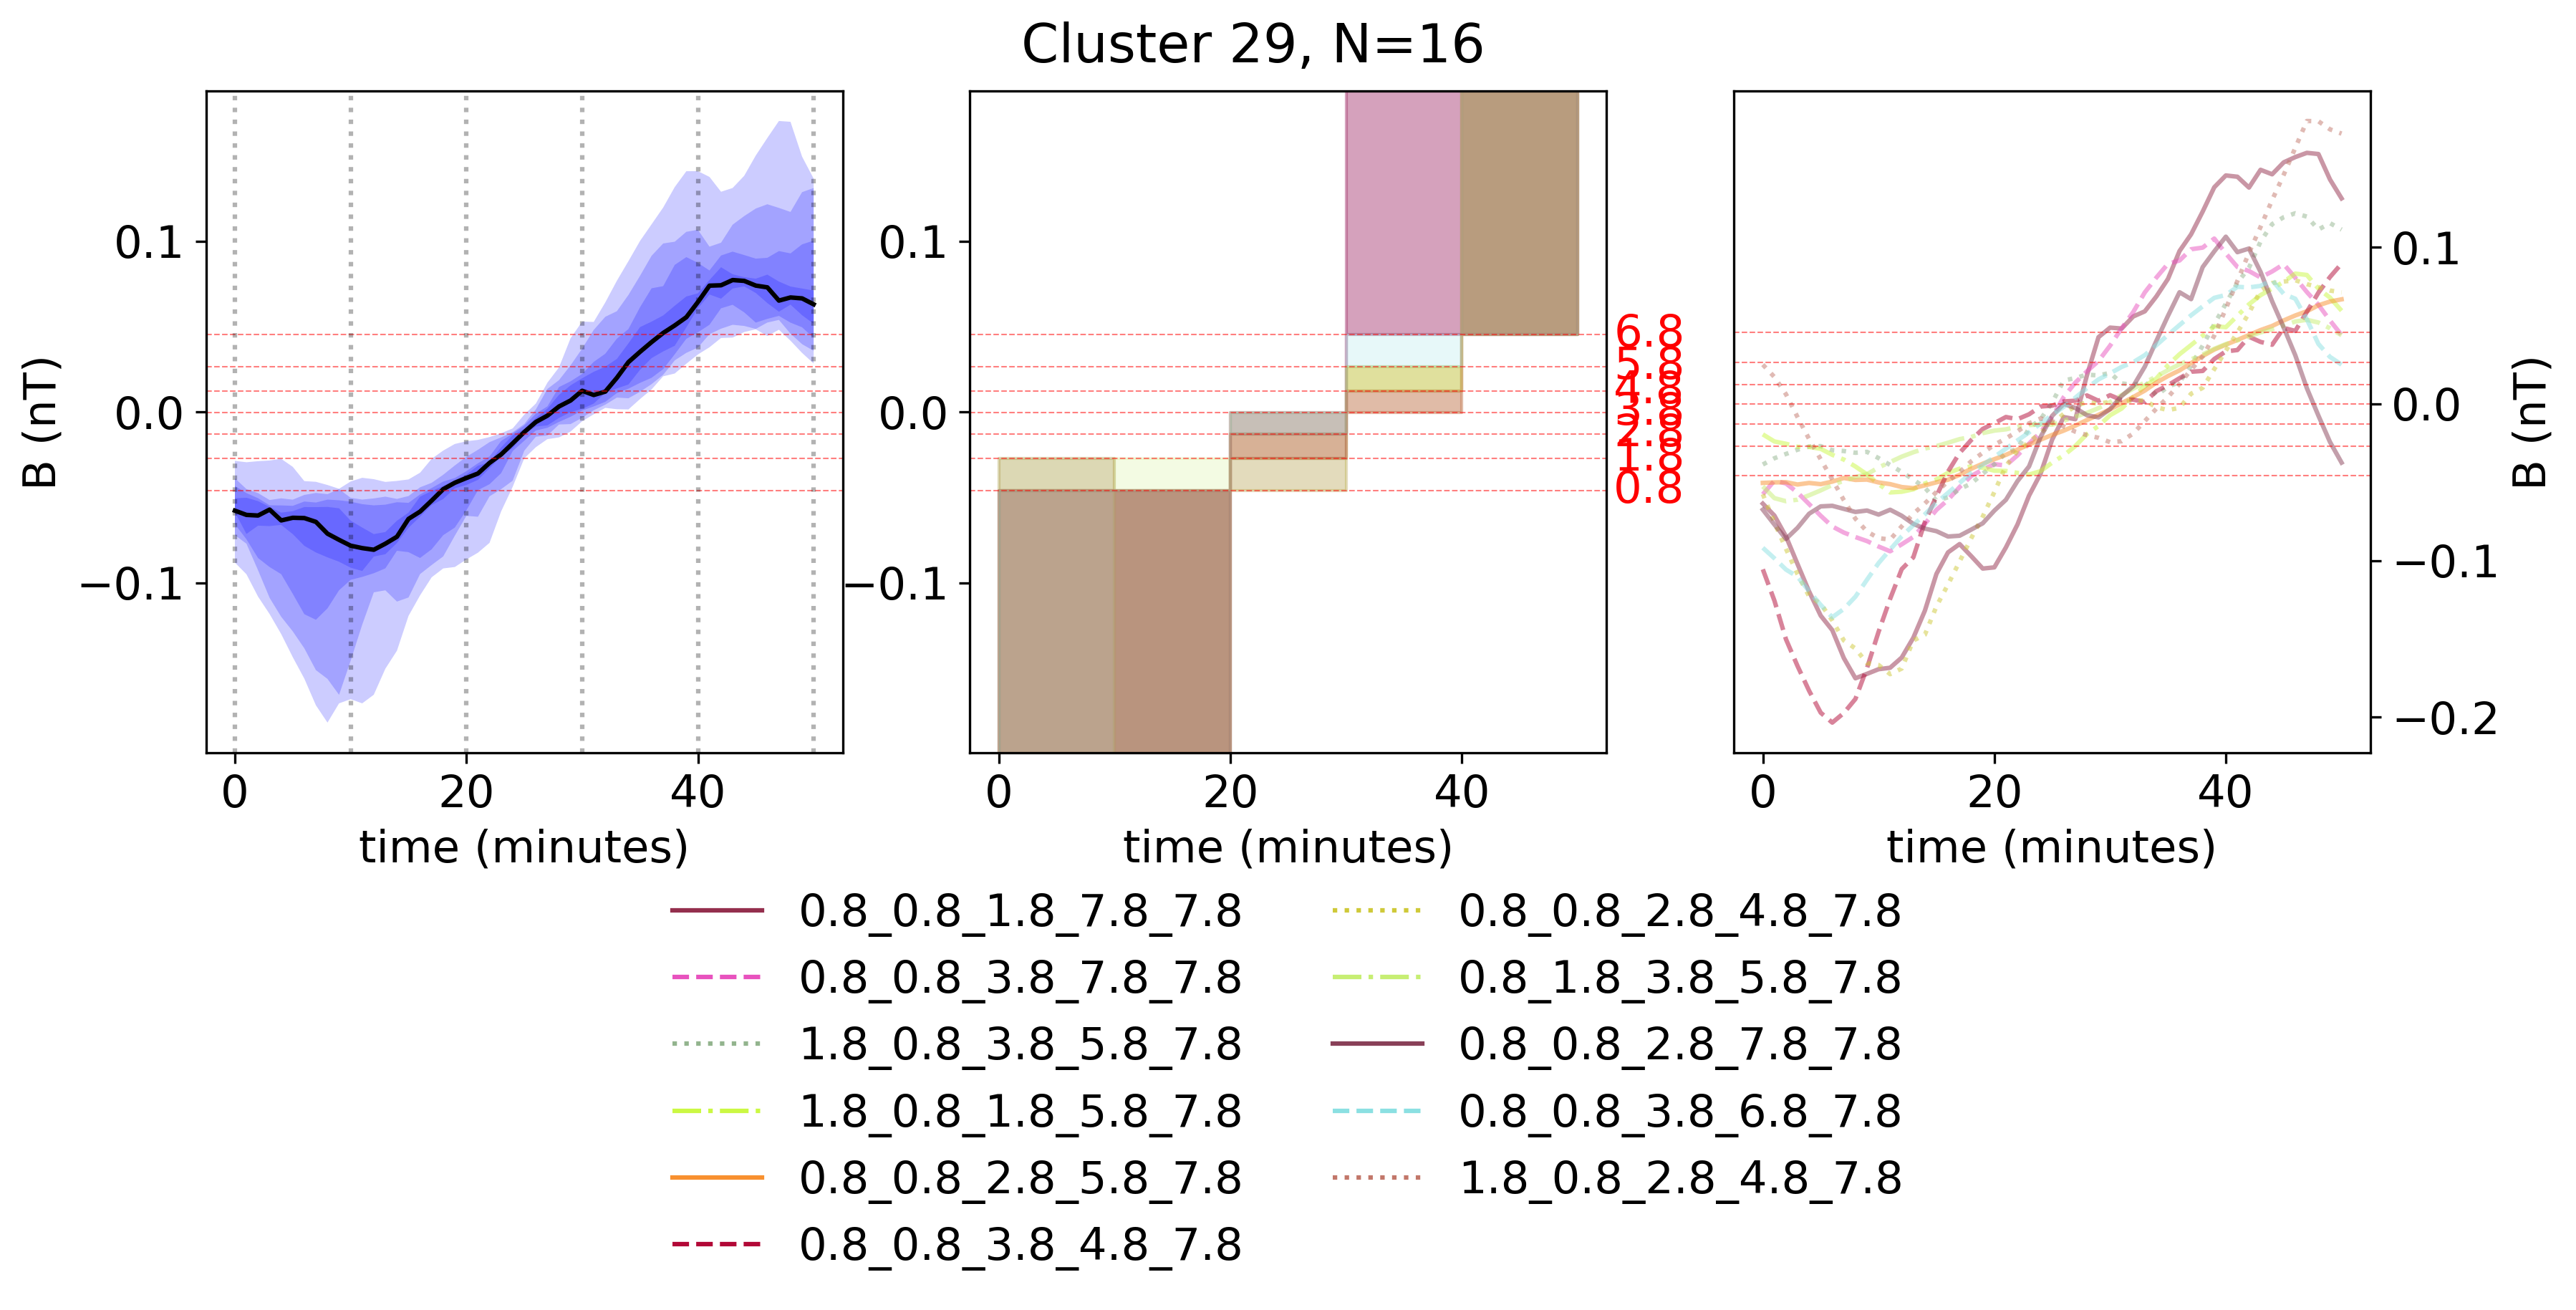

In [19]:
cluster = reindexed_cluster
cluster_n = max_cluster_label+1

fig_c = plot_cluster_curves(cluster_n, cluster, component, node_level_depth, isax_pipe, colors=100, max_t = 2*chunk_size.seconds,
                            cache=cache,instrument=instrument, cache_folder=cache_folder)

In [20]:
cluster = reindexed_cluster
cluster_n = -1
fig_c = plot_cluster_curves(cluster_n, cluster, component, node_level_depth, isax_pipe, colors=100, max_t = 2*chunk_size.seconds,
                            cache=cache,instrument=instrument, cache_folder=cache_folder)